In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


In [2]:
def getTestData():
    images = []
    for i in range(1, 4):
        images.append(cv.imread(f"img/test/test0{i}.jpg"))

    return images


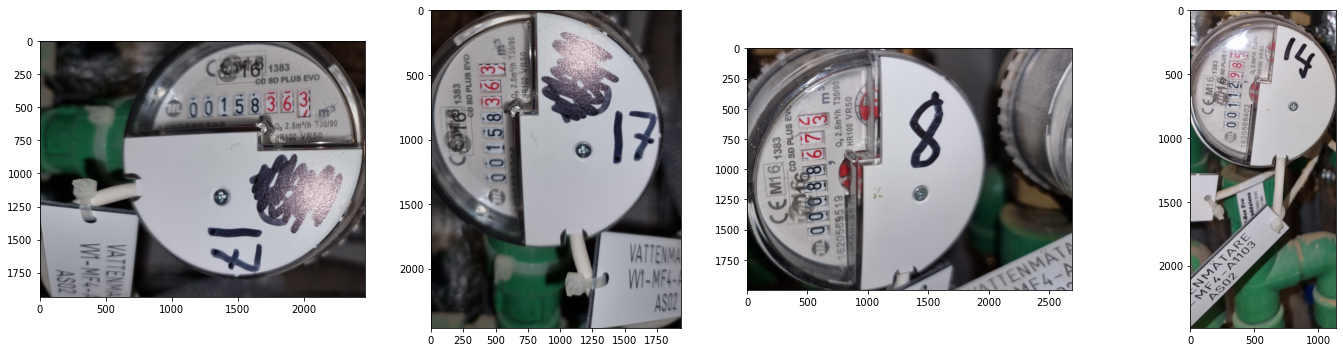

In [3]:
aliend = cv.imread("Aligned.jpg")
aliend_mask = cv.imread("./Aligned_maksed.jpg")

test_imgs = getTestData()

fig, ax = plt.subplots(1, 4)
fig.set_tight_layout("tight")
fig.set_size_inches(20, 5)
_ = ax[0].imshow(aliend[:, :, ::-1])
_ = ax[1].imshow(test_imgs[0][:, :, ::-1])
_ = ax[2].imshow(test_imgs[1][:, :, ::-1])
_ = ax[3].imshow(test_imgs[2][:, :, ::-1])


In [4]:
def get_matches(img1, img2):
    g_img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    g_img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

    orb = cv.ORB_create(500)
    keypoints_img1, descriptors1 = orb.detectAndCompute(g_img1, None)
    keypoints_img2, descriptors2 = orb.detectAndCompute(g_img2, None)

    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    matches = sorted(matches, key=lambda x: x.distance, reverse=True)

    numGoodMatches = int(len(matches) * 0.15)
    matches = matches[:numGoodMatches]

    return keypoints_img1, keypoints_img2, matches


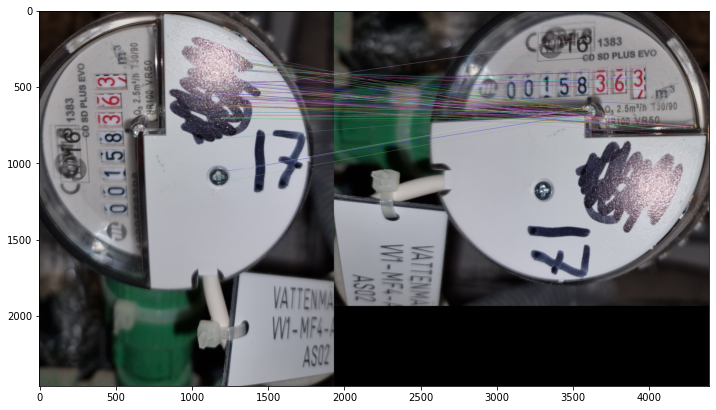

In [5]:
ix = 0
kp_test, kp_alined, matches = get_matches(test_imgs[ix], aliend_mask)
imMatches = cv.drawMatches(test_imgs[ix], kp_test, aliend, kp_alined, matches, None)
# imMatches = cv.drawMatches(test_imgs[ix], keypoints1, im2, keypoints2, matches, None)

fig, ax = plt.subplots()
fig.set_size_inches(12, 24)
_ = ax.imshow(imMatches[:, :, ::-1])


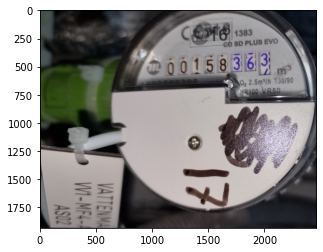

In [6]:
ix = 0
keypoints1, keypoints2, matches = get_matches(test_imgs[ix], aliend)

points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv.findHomography(points1, points2, cv.RANSAC)

# Use homography
height, width, channels = aliend.shape
im1Reg = cv.warpPerspective(test_imgs[ix], h, (width, height))

plt.imshow(im1Reg)


In [7]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15


def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
    im2Gray = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    # matches.sort(key=lambda x: x.distance, reverse=False)
    matches = sorted(matches, key=lambda x: x.distance, reverse=True)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    # print(f"{numGoodMatches = }", [m.distance for m in matches])

    # Draw top matches
    # imMatches = cv.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    # cv.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv.findHomography(points1, points2, cv.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv.warpPerspective(im1, h, (width, height))

    return im1Reg, h


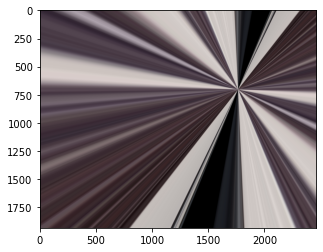

In [8]:
imReg, h = alignImages(test_imgs[0], aliend_mask)
plt.imshow(imReg)
